### To be run in colab

In [ ]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [ ]:
!pip install --quiet git+https://github.com/theislab/scgen.git

### Import the metric -- scib

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install --quiet scib
import scib

In [ ]:
!pip install --quiet louvain
import louvain

### Import the necessary library

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

In [5]:
import os
import tempfile

import gdown
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.external import CellAssign

In [6]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore", category=ImportWarning, message=".*AltairImportHook.find_spec() not found; falling back to find_module.*")

/opt/anaconda3/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


### read the data

In [19]:
# adata = anndata.read_h5ad("/content/drive/MyDrive/scdata/Lung_atlas_public/Lung_atlas_public.h5ad")
adata = anndata.read_h5ad("./human_immune.h5ad")
adata

/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/chemistry' was written without encoding metadata.
  return func(*ar

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [6]:
celltype_markers = pd.read_csv("./celltype.csv", index_col=0)

adata.obs.index = adata.obs.index.astype("str")
adata.var.index = adata.var.index.astype("str")
adata.var_names_make_unique()
adata.obs_names_make_unique()

adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [12]:
print(celltype_markers.index)

Index(['ACTA2', 'ARX', 'BANK1', 'CCL5', 'CD14', 'CD19', 'CD2', 'CD33', 'CD3D',
       'CD3E', 'CD3G', 'CD4', 'CD74', 'CD79A', 'CD79B', 'CD8A', 'CD8B', 'CDH1',
       'CDH5', 'CLEC14A', 'COL1A1', 'COL3A1', 'CXCR5', 'DCN', 'EMCN', 'EOMES',
       'EPCAM', 'FCGR3A', 'FOXL2', 'GZMA', 'ICA1', 'ICOS', 'IGKC', 'IGLC2',
       'IGLC3', 'IL7R', 'ITGAM', 'ITGAX', 'KRT8', 'LYZ', 'MCAM', 'MS4A1',
       'MUM1L1', 'MYH11', 'MYLK', 'NKG7', 'PDCD1', 'PECAM1', 'PLN', 'PTPRC',
       'RBP1', 'SERPINH1', 'ST8SIA1', 'TNFRSF4', 'TPT1', 'TRAC', 'VIM', 'VWF',
       'WFDC2'],
      dtype='object', name='Gene')


In [14]:
print(adata.var_names)

Index(['LINC00115', 'FAM41C', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'HES4',
       'ISG15', 'AGRN', 'TTLL10',
       ...
       'COL6A2', 'FTCD', 'LSS', 'MCM3AP-AS1', 'MCM3AP', 'YBEY', 'PCNT',
       'DIP2A', 'S100B', 'PRMT2'],
      dtype='object', name='index', length=12303)


In [16]:
lib_size = adata.X.sum(1)
adata.obs["size_factors"] = lib_size / np.mean(lib_size)

In [18]:
# Ensure that only the shared gene names between adata.var_names and celltype_markers.index are kept.
bdata = adata[:, adata.var_names.isin(celltype_markers.index)].copy()

In [20]:
print(bdata.var_names)

Index(['TNFRSF4', 'CD2', 'FCGR3A', 'PTPRC', 'CD8A', 'CD8B', 'ICOS', 'PDCD1',
       'EOMES', 'MYLK', 'RBP1', 'BANK1', 'IL7R', 'GZMA', 'CD14', 'CD74',
       'ICA1', 'MS4A1', 'SERPINH1', 'CD3E', 'CD3D', 'CD3G', 'CXCR5', 'VIM',
       'ACTA2', 'VWF', 'CD4', 'ST8SIA1', 'KRT8', 'LYZ', 'TPT1', 'MYH11',
       'CD19', 'ITGAM', 'ITGAX', 'CDH1', 'CCL5', 'COL1A1', 'CD79B', 'CD79A',
       'CD33', 'NKG7'],
      dtype='object', name='index')


## CellAssign

A size factor may be defined manually as scaled library size (total UMI count) and should not be placed on the log scale, as the model will do this manually. The library size should be computed before any gene subsetting (in this case, technically, a few notebook cells up).

In [23]:
scvi.external.CellAssign.setup_anndata(bdata, size_factor_key="size_factors")

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [25]:
model = CellAssign(bdata, celltype_markers)
model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 362/400:  90%|▉| 362/400 [11:41<01:13,  1.94s/it, v_num=1, train_loss_step
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 26.115. Signaling Trainer to stop.


In [26]:
predictions = model.predict()
predictions.head()

,B cells (kappa),B cells (lambda),Cytotoxic T cells,CD4 T cells,Tfh,Monocyte/Macrophage,Epithelial cells,Ovarian stromal cells,Ovarian myofibroblast,Vascular smooth muscle cells,Endothelial cells,other
0,1.324815e-05,2.417869e-26,2.477184e-35,2.834053e-15,2.738591e-10,1.885699e-20,0.992967,3.097434e-24,5.085817e-16,2.075468e-07,1.067473e-15,0.007019
1,2.440554e-07,4.189248e-28,1.620648e-23,3.158435e-11,5.375087e-12,2.475945e-10,0.999160,5.760669e-25,3.355043e-16,3.834962e-08,1.740501e-16,0.000840
2,5.366017e-06,3.947435e-27,2.831331e-25,3.383844e-15,8.529369e-11,1.526978e-18,0.994079,3.464184e-24,6.062214e-16,5.009352e-07,1.088475e-15,0.005915
3,2.405772e-06,2.236303e-27,4.368652e-35,4.930354e-14,3.284728e-11,7.228691e-18,0.996301,2.488202e-24,6.972684e-16,4.827104e-07,8.773849e-16,0.003696
4,1.710971e-06,2.419167e-28,3.282954e-43,3.144661e-31,9.512250e-19,5.934058e-09,0.999152,5.083188e-25,2.952293e-16,5.302537e-08,1.538320e-16,0.000846


In [ ]:
sns.clustermap(predictions, cmap="viridis")

In [27]:
bdata.obs["cellassign_predictions"] = predictions.idxmax(axis=1).values

In [28]:
print(bdata.obs["cellassign_predictions"])

index
AAACCTGCAGCGAACA-1-Oetjen_A      Epithelial cells
AAACCTGCATGTCCTC-1-Oetjen_A      Epithelial cells
AAACCTGGTCGACTGC-1-Oetjen_A      Epithelial cells
AAACCTGGTCGCTTCT-1-Oetjen_A      Epithelial cells
AAACCTGTCCCGACTT-1-Oetjen_A      Epithelial cells
                                       ...       
Mono_nonclassical_S96-Villani    Epithelial cells
Mono_nonclassical_S97-Villani    Epithelial cells
Mono_nonclassical_S98-Villani               other
Mono_nonclassical_S99-Villani    Epithelial cells
Mono_nonclassical_S9-Villani     Epithelial cells
Name: cellassign_predictions, Length: 33506, dtype: object


In [31]:
import pandas as pd

cellassign_predictions = bdata.obs["cellassign_predictions"]

# 将 "cellassign_predictions" 保存为 CSV 文件
cellassign_predictions.to_csv("./human_immune_cellassign_predictions.csv", index=True)

In [21]:
predictions = pd.read_csv("./human_immune_cellassign_predictions.csv")
adata.obs['predict_labels'] = predictions['cellassign_predictions'].values

In [23]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

In [24]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

# scANVI

In [ ]:
# scVI
adata = adata.copy()
adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [ ]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

In [ ]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [29]:
import scvi

# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     File ./model_scVI/model.pt already downloaded                                                             


/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [30]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="predict_labels",
    unlabeled_category="Unknown",
)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 1 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 1 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [33]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|█| 20/20 [01:33<00:00,  4.68s/it, v_num=1, train_loss_step=541

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [01:33<00:00,  4.70s/it, v_num=1, train_loss_step=541


In [34]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [35]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict['X_scANVI'] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [36]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


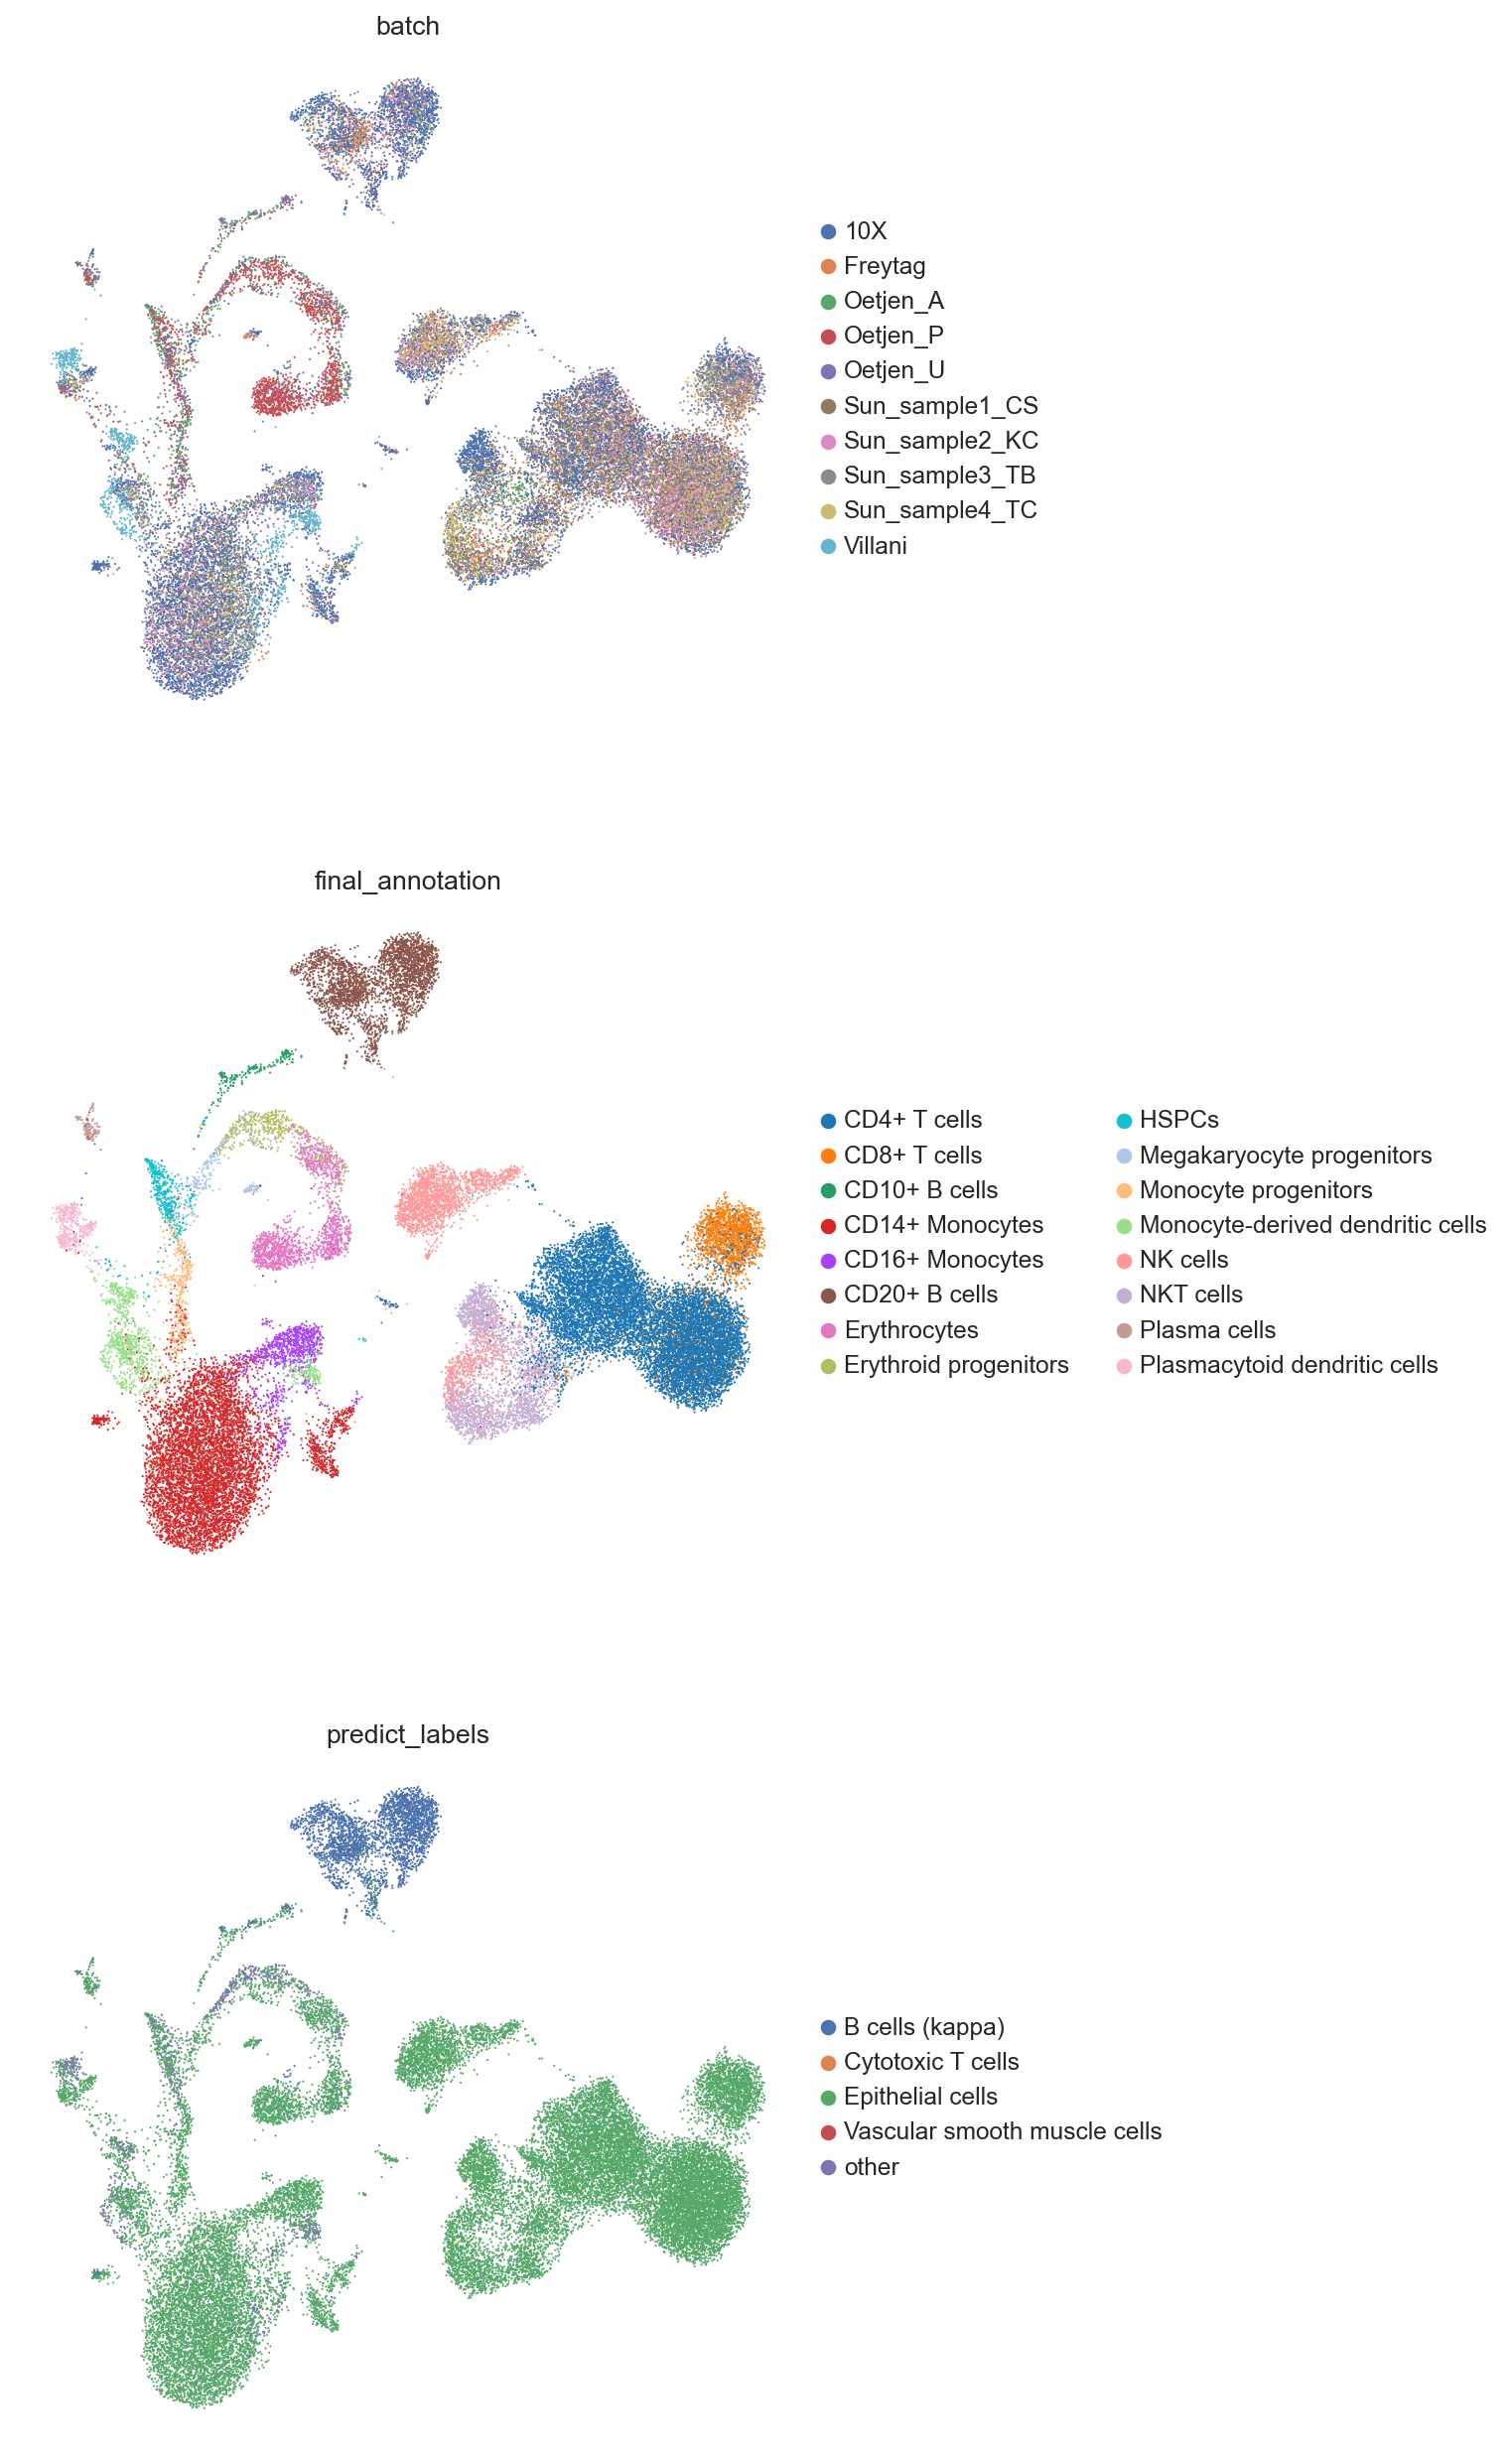

In [37]:
sc.pl.umap(adata, color=["batch", "final_annotation", "predict_labels"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [38]:
train = adata.copy()

### Preprocessing Data

In [40]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="predict_labels")

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 1 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


## Creating and Training the model¶

In [42]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 27/100:  27%|▎| 27/100 [06:18<17:04, 14.03s/it, v_num=1, train_loss_step=2
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1183.428. Signaling Trainer to stop.


## Batch-Removal

In [44]:
corrected_adata = model.batch_removal()
corrected_adata

/opt/anaconda3/lib/python3.12/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(
/opt/anaconda3/lib/python3.12/site-packages/scgen/_scgen.py:293: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_not_shared_ann = AnnData.concatenate(
/opt/anaconda3/lib/python3.12/site-packages/scgen/_scgen.py:296: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_corrected_data = AnnData.concatena

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:224: UserWarning: Category 1 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


AnnData object with n_obs × n_vars = 33506 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'predict_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'concat_batch'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [45]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [47]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


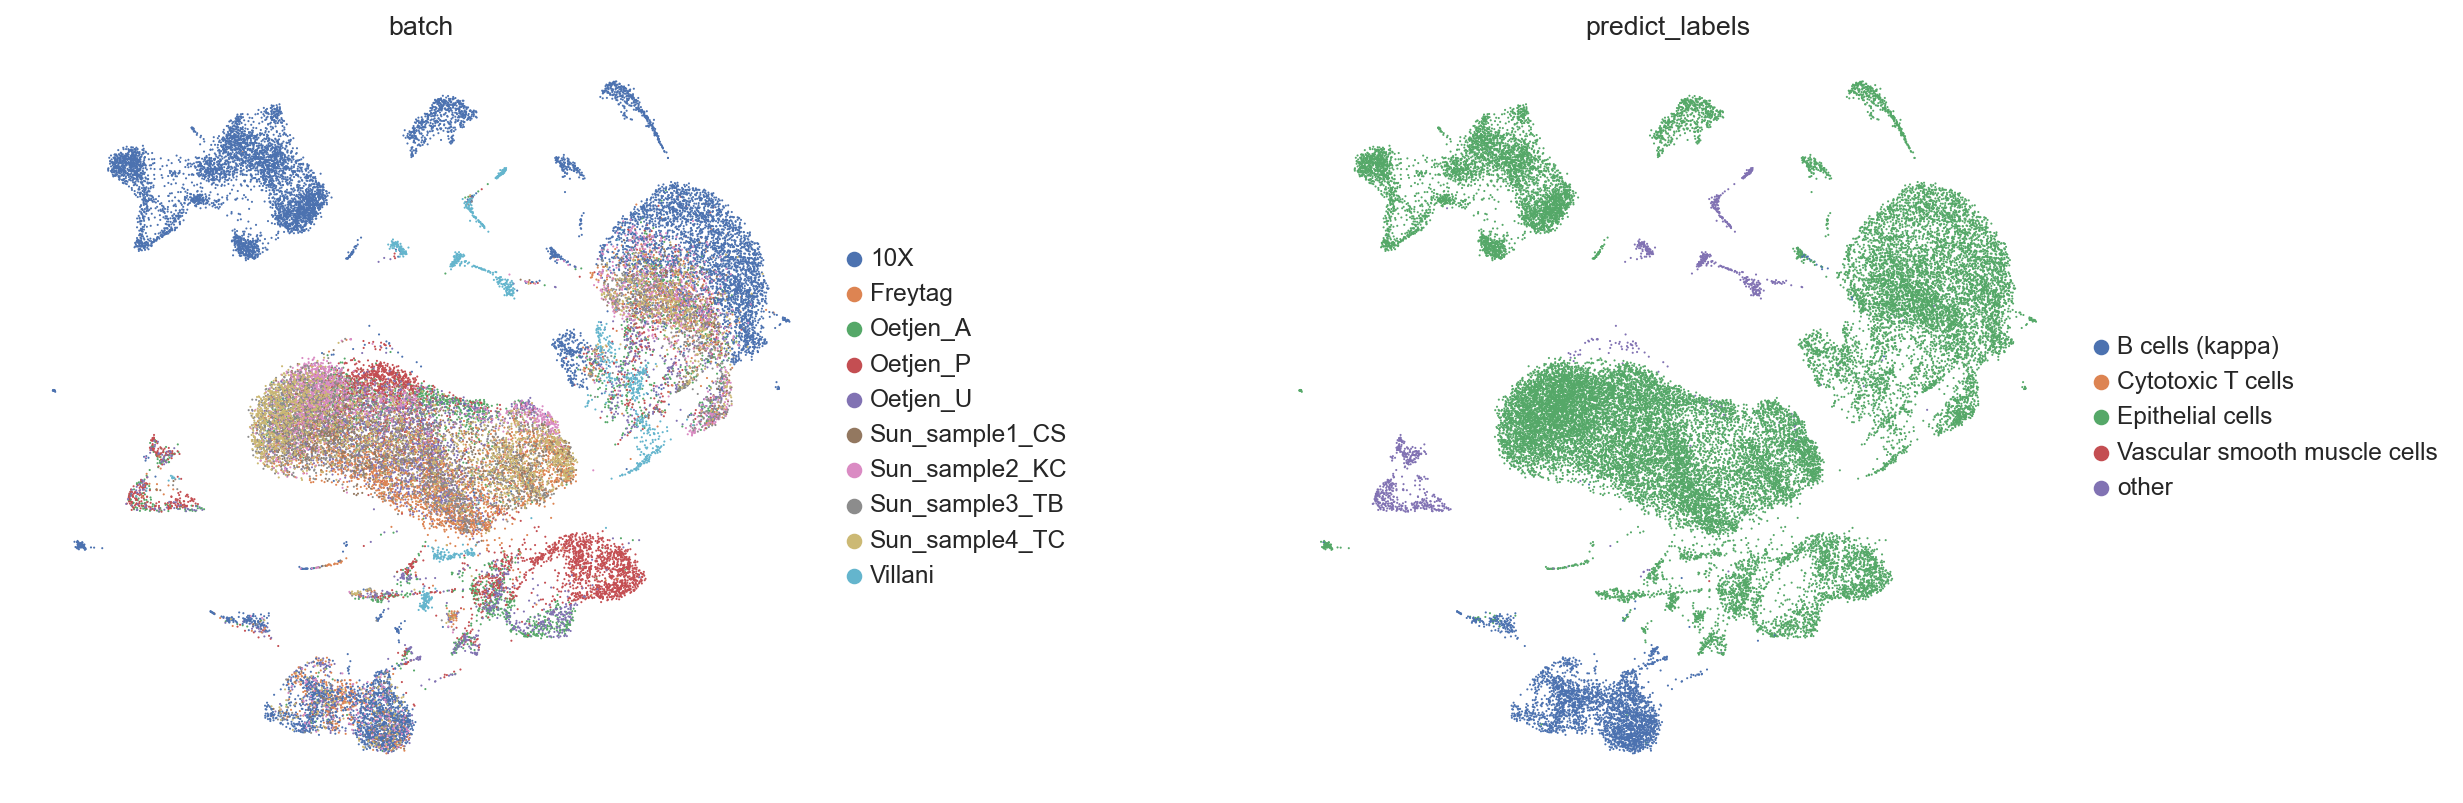

In [48]:
sc.pl.umap(corrected_adata, color=['batch', 'final_annotation', 'predict_labels'], wspace=0.4, frameon=False, ncols=1)

# STACAS

Semi-supervised integration results

In [62]:
pca_embeddings = pd.read_csv('./human_immune_stacas_embeddings_cell_assign.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [63]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

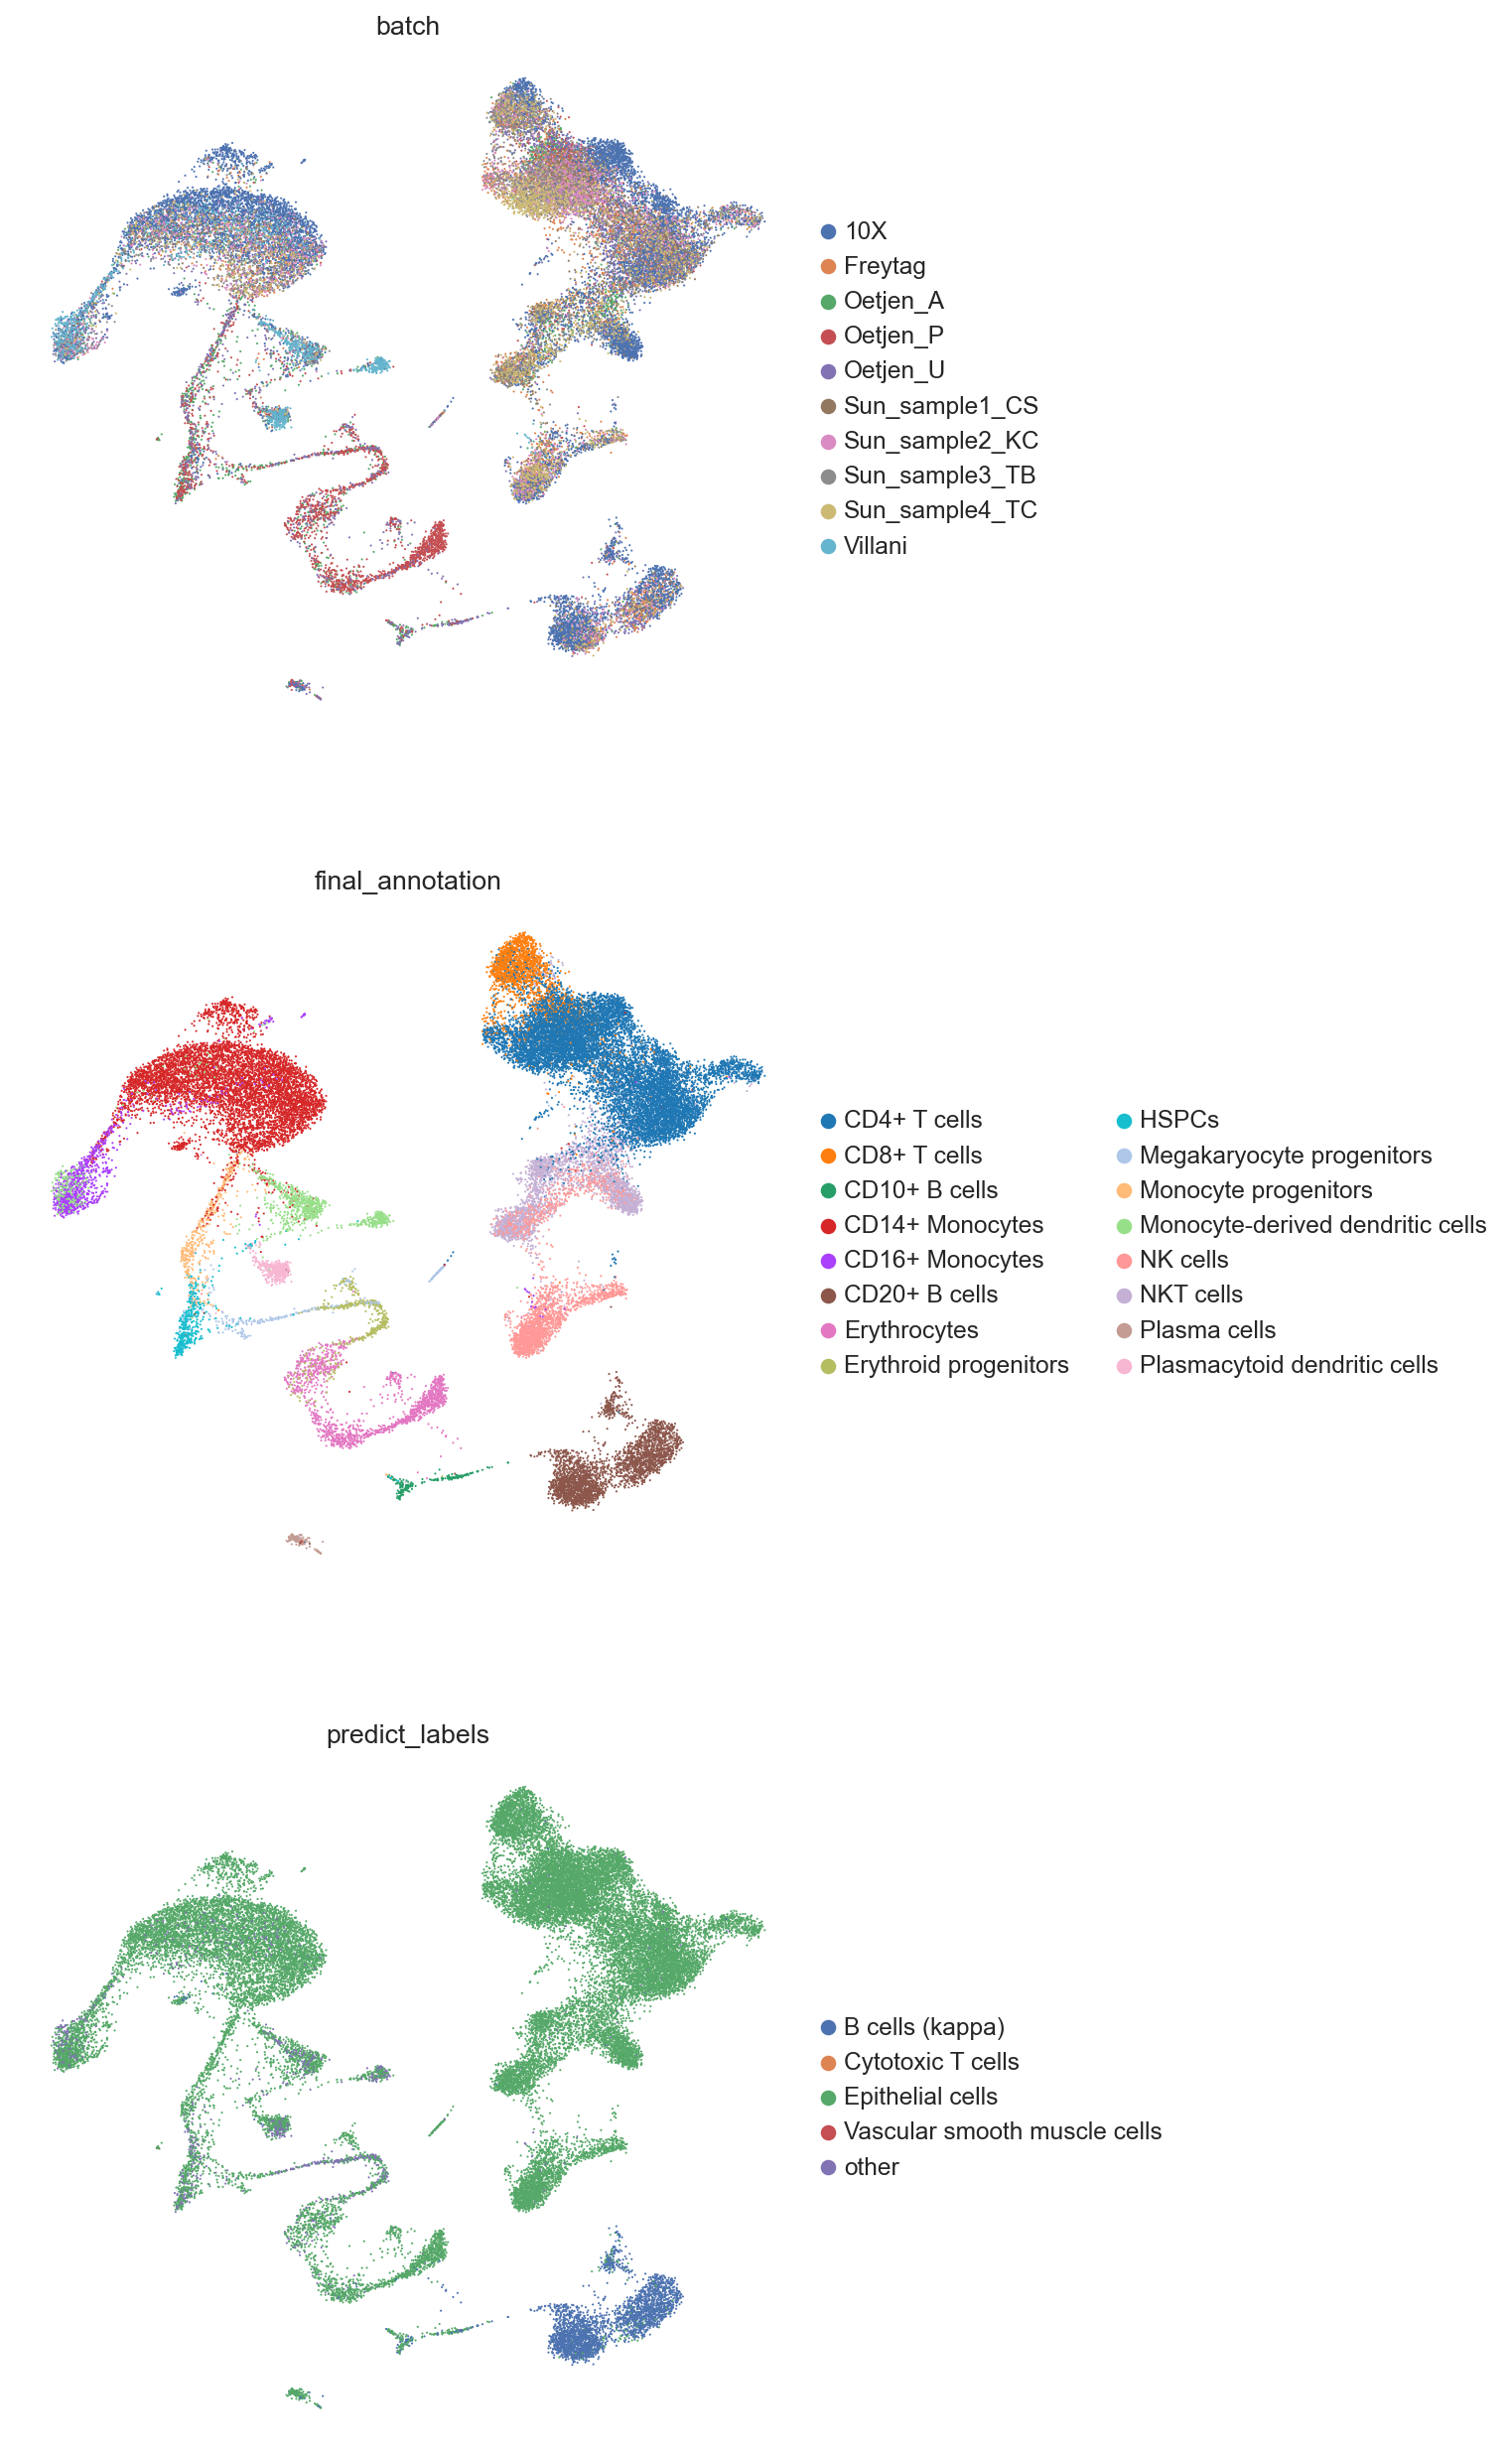

In [64]:
sc.pl.umap(adata, color=["batch", "final_annotation", 'predict_labels'], frameon=False, ncols=1)

In [65]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("./cell_assign_human_immune.csv")


# Metric Evaluation

## read the embeddings

In [70]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("./cell_assign_human_immune.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

## Bio-conservation

In [92]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df1_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.7830423059792291
resolution: 0.2, nmi: 0.8181366128161198
resolution: 0.3, nmi: 0.8244866602967537
resolution: 0.4, nmi: 0.7908598690534405
resolution: 0.5, nmi: 0.7880096112829348
resolution: 0.6, nmi: 0.7891007520083764
resolution: 0.7, nmi: 0.7822079837150678
resolution: 0.8, nmi: 0.7725628029526435
resolution: 0.9, nmi: 0.7425920245468205
resolution: 1.0, nmi: 0.7433250552915464
resolution: 1.1, nmi: 0.7419301858259084
resolution: 1.2, nmi: 0.7305860716739779
resolution: 1.3, nmi: 0.7311301320912643
resolution: 1.4, nmi: 0.723322459178394
resolution: 1.5, nmi: 0.7011895583959235
resolution: 1.6, nmi: 0.7074826535169452
resolution: 1.7, nmi: 0.6891057385442585
resolution: 1.8, nmi: 0.6796422980791326
resolution: 1.9, nmi: 0.670070770012309
resolution: 2.0, nmi: 0.6740940130769009
optimised clustering against final_annotation
optimal cluster resolution: 0.3
optimal score: 0.8244866602967537


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scANVI


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [96]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df2_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_scgen')

resolution: 0.1, nmi: 0.5988599658202429
resolution: 0.2, nmi: 0.6321511324994582
resolution: 0.3, nmi: 0.6687248258716402
resolution: 0.4, nmi: 0.6541354666658918
resolution: 0.5, nmi: 0.6591673611108055
resolution: 0.6, nmi: 0.6712116045198613
resolution: 0.7, nmi: 0.6634100219431427
resolution: 0.8, nmi: 0.6670449296727979
resolution: 0.9, nmi: 0.6586740001563745
resolution: 1.0, nmi: 0.6780307954529919
resolution: 1.1, nmi: 0.6854162244059667
resolution: 1.2, nmi: 0.6653302174546886
resolution: 1.3, nmi: 0.679966473138934
resolution: 1.4, nmi: 0.67776571936543
resolution: 1.5, nmi: 0.6745064562338157
resolution: 1.6, nmi: 0.6737724853429959
resolution: 1.7, nmi: 0.666730694152646
resolution: 1.8, nmi: 0.6523522936978983
resolution: 1.9, nmi: 0.6480377026750445
resolution: 2.0, nmi: 0.6517714018357341
optimised clustering against final_annotation
optimal cluster resolution: 1.1
optimal score: 0.6854162244059667


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scgen


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [97]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df3_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_stacas')

resolution: 0.1, nmi: 0.8277832562400204
resolution: 0.2, nmi: 0.7986731944238791
resolution: 0.3, nmi: 0.7899724853596829
resolution: 0.4, nmi: 0.7917304761113104
resolution: 0.5, nmi: 0.7783734988679226
resolution: 0.6, nmi: 0.7712403209481576
resolution: 0.7, nmi: 0.7501892470051049
resolution: 0.8, nmi: 0.7455938123340905
resolution: 0.9, nmi: 0.7476293099935178
resolution: 1.0, nmi: 0.7368346601849045
resolution: 1.1, nmi: 0.7366110346483569
resolution: 1.2, nmi: 0.7342409950544909
resolution: 1.3, nmi: 0.7310574298649569
resolution: 1.4, nmi: 0.7208714165998938
resolution: 1.5, nmi: 0.7106289381371577
resolution: 1.6, nmi: 0.6968019205168511
resolution: 1.7, nmi: 0.6897823420583516
resolution: 1.8, nmi: 0.6895389466844719
resolution: 1.9, nmi: 0.6872113401152067
resolution: 2.0, nmi: 0.6809301467912836
optimised clustering against final_annotation
optimal cluster resolution: 0.1
optimal score: 0.8277832562400204


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_stacas


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [105]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.820384,0.673316,0.813101
ARI_cluster/label,0.832184,0.420006,0.767722
ASW_label,0.583570,0.537737,0.596988
ASW_label/batch,0.878271,0.907663,0.897226
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.839742,0.774415,0.848636
isolated_label_silhouette,0.634527,0.584687,0.645206
graph_conn,0.973523,0.915176,0.967187
kBET,NaN,NaN,NaN


In [90]:
# trying kBET and lisi
import metrics
import scib
from scib.metrics import lisi

# 定义不同的嵌入方法
embeddings = ["X_scANVI", "X_scgen", "X_stacas"] 

# 用于存储结果的列表
results_list = []

# 循环通过所有的方法，评估每个嵌入的效果
for embed in embeddings:
    result = metrics.calculate_metrics(
        adata=adata,
        batch_key='batch',  # 替换为你数据中的batch键
        celltype_key='final_annotation',  # 替换为你数据中的celltype键
        all=True,  # 如果你想计算所有度量，包括LISI和正/真阳率
        embed=embed  # 传递当前循环的嵌入方法
    )
    result['embedding'] = embed  # 添加一列以标识嵌入方法
    results_list.append(result)

# 将所有结果汇总到一个DataFrame中
final_results_df = pd.concat(results_list)

# 打印结果
print(final_results_df)


LISI---


NameError: name 'lisi' is not defined